In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### PREPROCESS DATA

In [2]:
# --- Load and subset columns ---
df = pd.read_csv("datasets/Chamau_2001-2024.csv")

cols = [
    # Target
    "FN2O_L3.1_L3.3_CUT_50_QCF0",

    # Timestamp
    "TIMESTAMP_MIDDLE",
    
    # Predictors
    "NEE_L3.1_L3.3_CUT_50_QCF_gfRF",
    "GPP_NT_CUT_50_gfRF",
    "RECO_NT_CUT_50_gfRF",
    "SW_IN_T1_2_1",
    "TA_T1_2_1",
    "PREC_RAIN_TOT_GF1_0.5_1",
    "VPD_T1_2_1",
    "SWC_GF1_0.05_1",
    "SWC_GF1_0.15_1",
    "TS_GF1_0.04_1",
    "TS_GF1_0.15_1",
    "MGMT_MOWING_PARCEL-A",
    "MGMT_FERT_ORG_PARCEL-A",
    "MGMT_FERT_MIN_PARCEL-A",
    "MGMT_GRAZING_PARCEL-A",
    "MGMT_SOILCULTIVATION_PARCEL-A",
    "MGMT_MOWING_PARCEL-B",
    "MGMT_FERT_ORG_PARCEL-B",
    "MGMT_FERT_MIN_PARCEL-B",
    "MGMT_GRAZING_PARCEL-B",
    "MGMT_SOILCULTIVATION_PARCEL-B",
    "WD",
]

chamau = df[cols].rename(columns={
    "FN2O_L3.1_L3.3_CUT_50_QCF0": "N2O_Flux",
    "TIMESTAMP_MIDDLE": "Timestamp",
    "NEE_L3.1_L3.3_CUT_50_QCF_gfRF": "NEE",
    "GPP_NT_CUT_50_gfRF": "GPP",
    "RECO_NT_CUT_50_gfRF": "RECO",
    "SW_IN_T1_2_1": "SolarRadiation",
    "TA_T1_2_1": "AirTemp",
    "PREC_RAIN_TOT_GF1_0.5_1": "Precipitation",
    "VPD_T1_2_1": "VPD",
    "SWC_GF1_0.05_1": "SoilWater_5cm",
    "SWC_GF1_0.15_1": "SoilWater_15cm",
    "TS_GF1_0.04_1": "SoilTemp_4cm",
    "TS_GF1_0.15_1": "SoilTemp_15cm",
})

# --- Parse datetime ---
chamau["Timestamp"] = pd.to_datetime(chamau["Timestamp"])
chamau = chamau.sort_values("Timestamp")

chamau["year"] = chamau["Timestamp"].dt.year
chamau["month"] = chamau["Timestamp"].dt.month
chamau["hour"] = chamau["Timestamp"].dt.hour

# --- Attribute parcel by wind direction ---
def assign_parcel(wd):
    if 110 <= wd <= 210:
        return "A"
    elif (wd >= 290) or (wd <= 30):
        return "B"
    else:
        return np.nan

chamau["Parcel"] = chamau["WD"].apply(assign_parcel)
chamau = chamau[chamau["Parcel"].notna()]  # keep only A/B

# --- Merge parcel-specific management columns ---
management_map = {
    "A": {
        "Mowing": "MGMT_MOWING_PARCEL-A",
        "FertilizerOrganic": "MGMT_FERT_ORG_PARCEL-A",
        "FertilizerMineral": "MGMT_FERT_MIN_PARCEL-A",
        "Grazing": "MGMT_GRAZING_PARCEL-A",
        "SoilCultivation": "MGMT_SOILCULTIVATION_PARCEL-A",
    },
    "B": {
        "Mowing": "MGMT_MOWING_PARCEL-B",
        "FertilizerOrganic": "MGMT_FERT_ORG_PARCEL-B",
        "FertilizerMineral": "MGMT_FERT_MIN_PARCEL-B",
        "Grazing": "MGMT_GRAZING_PARCEL-B",
        "SoilCultivation": "MGMT_SOILCULTIVATION_PARCEL-B",
    },
}

for event in ["Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"]:
    chamau[event] = np.where(
        chamau["Parcel"] == "A",
        chamau[management_map["A"][event]],
        chamau[management_map["B"][event]],
    )

drop_mgmt_cols = [
    "MGMT_MOWING_PARCEL-A", "MGMT_FERT_ORG_PARCEL-A", "MGMT_FERT_MIN_PARCEL-A",
    "MGMT_GRAZING_PARCEL-A", "MGMT_SOILCULTIVATION_PARCEL-A",
    "MGMT_MOWING_PARCEL-B", "MGMT_FERT_ORG_PARCEL-B", "MGMT_FERT_MIN_PARCEL-B",
    "MGMT_GRAZING_PARCEL-B", "MGMT_SOILCULTIVATION_PARCEL-B"
]

chamau = chamau.drop(columns=drop_mgmt_cols, errors="ignore")

# --- Prepare for lag feature computation ---
chamau = chamau.set_index("Timestamp").sort_index()

# Continuous predictors for lags
meteo_predictors = [
    "NEE", "GPP", "RECO",
    "SolarRadiation", "AirTemp", "Precipitation", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm"
]

lags_days = [1, 3, 5, 7]

# Compute lags
for var in meteo_predictors:
    for lag in lags_days:
        chamau[f"{var}_lag{lag}d"] = chamau[var].shift(freq=pd.Timedelta(days=lag))

# --- Compute days since last management event (per parcel) ---
def days_since_event(series, max_days=30):
    """Days since last management event, capped at max_days."""
    days = np.full(len(series), np.nan)
    last_event_idx = None
    for i, val in enumerate(series):
        if val == 1:
            last_event_idx = i
            days[i] = 0
        elif last_event_idx is not None:
            delta = (series.index[i] - series.index[last_event_idx]).total_seconds() / 86400
            days[i] = min(delta, max_days)
        else:
            days[i] = max_days
    return days

# Apply separately per parcel to ensure independence
chamau_list = []
for parcel, group in chamau.groupby("Parcel"):
    group = group.copy()
    for event in ["Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"]:
        group[f"DaysSince_{event}"] = days_since_event(group[event])
    chamau_list.append(group)

chamau_lag = pd.concat(chamau_list).sort_index()

chamau_lag_full = chamau_lag.copy()

# --- Filter for analysis period (2014 onwards), keeping earlier lags intact ---
chamau_lag = chamau_lag[chamau_lag["year"] >= 2014]
chamau_lag = chamau_lag[chamau_lag["N2O_Flux"].notna()]

# --- transformation ---
chamau_lag["N2O_Flux_ln"] = np.where(
    chamau_lag["N2O_Flux"] > 0,
    np.log1p(chamau_lag["N2O_Flux"]),
    0  # replace neg with 0
)

# --- create separate dataframes per parcel ---
chamau_A = chamau_lag[chamau_lag["Parcel"] == "A"].copy()
chamau_B = chamau_lag[chamau_lag["Parcel"] == "B"].copy()

chamau_lag.head()

/home/anding/miniconda3/envs/dsl/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


N2O_Flux       NEE       GPP      RECO  SolarRadiation  \
Timestamp                                                                     
2014-01-01 08:15:00  0.452479  1.376340  0.030400  1.406740        0.000000   
2014-01-01 12:45:00 -0.225470 -6.210069  7.903790  1.693721      338.670013   
2014-01-02 10:45:00  0.576500 -2.106905  3.698460  1.591555       41.875999   
2014-01-03 06:45:00  0.213546  0.889902  0.538412  1.428313        0.000000   
2014-01-03 08:15:00  0.219524  1.107882  0.332309  1.440191        0.000000   

                     AirTemp  Precipitation       VPD  SoilWater_5cm  \
Timestamp                                                              
2014-01-01 08:15:00 -0.29593         0.0000  0.000078      58.519489   
2014-01-01 12:45:00  6.66320         0.0000  0.337488      58.570511   
2014-01-02 10:45:00  2.20970         0.2634  0.000000      58.430313   
2014-01-03 06:45:00 -2.38820         0.0000  0.000195      58.576870   
2014-01-03 08:15:00 -2.18680         0.0000  0.000239      58.572620   

                     SoilWater_15cm  SoilTemp_4cm  SoilTemp_15cm       WD  \
Timestamp                                                                   
2014-01-01 08:15:00       47.391090        1.3564         2.4593  125.987   
2014-01-01 12:45:00       47.384388        1.6403         2.4087  162.609   
2014-01-02 10:45:00       47.326595        1.6977         2.4842  146.439   
2014-01-03 06:45:00       47.360085        1.6568         2.5283  345.405   
2014-01-03 08:15:00       47.359261        1.6183         2.5398  157.497   

                     year  month  hour Parcel  Mowing  FertilizerOrganic  \
Timestamp                                                                  
2014-01-01 08:15:00  2014      1     8      A     0.0                0.0   
2014-01-01 12:45:00  2014      1    12      A     0.0                0.0   
2014-01-02 10:45:00  2014      1    10      A     0.0                0.0   
2014-01-03 06:45:00  2014      1     6      B     0.0                0.0   
2014-01-03 08:15:00  2014      1     8      A     0.0                0.0   

                     FertilizerMineral  Grazing  SoilCultivation  NEE_lag1d  \
Timestamp                                                                     
2014-01-01 08:15:00                0.0      0.0              0.0   0.897955   
2014-01-01 12:45:00                0.0      0.0              0.0  -8.516430   
2014-01-02 10:45:00                0.0      0.0              0.0  -6.318084   
2014-01-03 06:45:00                0.0      0.0              0.0   1.100591   
2014-01-03 08:15:00                0.0      0.0              0.0   1.365861   

                     NEE_lag3d  NEE_lag5d  NEE_lag7d  GPP_lag1d  GPP_lag3d  \
Timestamp                                                                    
2014-01-01 08:15:00   1.163853   0.874649   2.806831   0.338803   0.008870   
2014-01-01 12:45:00  -5.621324        NaN  -5.622183   9.996508   7.103336   
2014-01-02 10:45:00        NaN  -5.929594  -6.995715   7.839819        NaN   
2014-01-03 06:45:00        NaN   1.458496   0.912255   0.345395        NaN   
2014-01-03 08:15:00   0.897955   1.163853   0.874649   0.121523   0.338803   

                     GPP_lag5d  GPP_lag7d  RECO_lag1d  RECO_lag3d  RECO_lag5d  \
Timestamp                                                                       
2014-01-01 08:15:00   0.220744  -1.600932    1.236758    1.172723    1.095393   
2014-01-01 12:45:00        NaN   7.007417    1.480078    1.482011         NaN   
2014-01-02 10:45:00   7.120476   8.228259    1.521735         NaN    1.190882   
2014-01-03 06:45:00  -0.220382   0.212931    1.445987         NaN    1.238114   
2014-01-03 08:15:00   0.008870   0.220744    1.487385    1.236758    1.172723   

                     RECO_lag7d  SolarRadiation_lag1d  SolarRadiation_lag3d  \
Timestamp                                                                     
2014-01-01 08:15:00    1.205899              0.000000         

In [5]:
# Round timestamps down to the calendar day
chamau_lag_full["Date"] = chamau_lag_full.index.floor("D")

# --- Aggregate daily per parcel ---
chamau_daily = (
    chamau_lag_full
    .groupby(["Parcel", "Date"], dropna=False)
    .agg({
        # Continuous fluxes and predictors — daily mean
        "N2O_Flux": "mean",
        "NEE": "mean",
        "GPP": "mean",
        "RECO": "mean",
        "SolarRadiation": "mean",
        "AirTemp": "mean",
        "VPD": "mean",
        "SoilWater_5cm": "mean",
        "SoilWater_15cm": "mean",
        "SoilTemp_4cm": "mean",
        "SoilTemp_15cm": "mean",

        # Precipitation — total per day
        "Precipitation": "sum",

        # Management events — any event that day
        "Mowing": "max",
        "FertilizerOrganic": "max",
        "FertilizerMineral": "max",
        "Grazing": "max",
        "SoilCultivation": "max",

        # Days since management — take min (closest to event)
        "DaysSince_Mowing": "min",
        "DaysSince_FertilizerOrganic": "min",
        "DaysSince_FertilizerMineral": "min",
        "DaysSince_Grazing": "min",
        "DaysSince_SoilCultivation": "min",

        # Wind direction — mean
        "WD": "mean",
    })
    .reset_index()
    .sort_values(["Parcel", "Date"])
)

print(f"Aggregated daily per parcel: {chamau_daily.shape}")

# ==========================================================
# --- Compute lag features (calendar-based, per parcel) ---
# ==========================================================
meteo_predictors = [
    "NEE", "GPP", "RECO",
    "SolarRadiation", "AirTemp", "Precipitation", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm"
]
lags_days = [1, 3, 5, 7]

# Initialize container for both parcels
daily_list = []

for parcel, group in chamau_daily.groupby("Parcel"):
    group = group.sort_values("Date").set_index("Date")

    for var in meteo_predictors:
        for lag in lags_days:
            group[f"{var}_lag{lag}d"] = group[var].shift(freq=pd.Timedelta(days=lag))

    # Restore Parcel column and append
    group["Parcel"] = parcel
    daily_list.append(group.reset_index())

# Recombine both parcels
chamau_daily = pd.concat(daily_list, ignore_index=True)

# ==========================================================
# --- Add temporal helpers and filter analysis period ---
# ==========================================================
chamau_daily["Date"] = pd.to_datetime(chamau_daily["Date"])
chamau_daily["year"] = chamau_daily["Date"].dt.year
chamau_daily["month"] = chamau_daily["Date"].dt.month
chamau_daily = chamau_daily[chamau_daily["year"] >= 2014]
chamau_daily = chamau_daily[chamau_daily["N2O_Flux"].notna()]

# ==========================================================
# --- Recalculate log-transform (after aggregation) ---
# ==========================================================
chamau_daily["N2O_Flux_ln"] = np.where(
    chamau_daily["N2O_Flux"] > 0,
    np.log1p(chamau_daily["N2O_Flux"]),
    0
)

# ==========================================================
# --- Split into Parcel A / B and combined ---
# ==========================================================
chamau_daily_A = chamau_daily[chamau_daily["Parcel"] == "A"].set_index("Date").sort_index()
chamau_daily_B = chamau_daily[chamau_daily["Parcel"] == "B"].set_index("Date").sort_index()

# Combined flat version
chamau_daily = chamau_daily.reset_index(drop=True)

# ==========================================================
# --- Final summary ---
# ==========================================================
print(f"Parcel A: {chamau_daily_A.shape}, index unique = {chamau_daily_A.index.is_unique}")
print(f"Parcel B: {chamau_daily_B.shape}, index unique = {chamau_daily_B.index.is_unique}")
print(f"Combined: {chamau_daily.shape}")
chamau_daily.head(3)


Aggregated daily per parcel: (13373, 25)
Parcel A: (1275, 71), index unique = True
Parcel B: (1633, 71), index unique = True
Combined: (2908, 72)


/home/anding/miniconda3/envs/dsl/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Date Parcel  N2O_Flux       NEE       GPP      RECO  SolarRadiation  \
0 2014-01-01      A  0.113504 -0.431513  1.855290  1.423777       57.185453   
1 2014-01-02      A  0.576500  1.113332  0.384247  1.497579        8.145214   
2 2014-01-03      A  0.414983  0.502977  1.050032  1.553009       22.994107   

    AirTemp       VPD  SoilWater_5cm  SoilWater_15cm  SoilTemp_4cm  \
0 -0.038861  0.030485      58.517817       47.376410      1.706039   
1 -0.072063  0.000128      58.505171       47.334073      2.047250   
2  0.203489  0.000106      58.527362       47.361109      1.972250   

   SoilTemp_15cm  Precipitation  Mowing  FertilizerOrganic  FertilizerMineral  \
0       2.582958         0.1317     0.0                0.0                0.0   
1       2.686911         0.5268     0.0                0.0                0.0   
2       2.595504         0.1317     0.0                0.0                0.0   

   Grazing  SoilCultivation  DaysSince_Mowing  DaysSince_FertilizerOrganic  \
0      0.0              0.0              30.0                         30.0   
1      0.0              0.0              30.0                         30.0   
2      0.0              0.0              30.0                         30.0   

   DaysSince_FertilizerMineral  DaysSince_Grazing  DaysSince_SoilCultivation  \
0                         30.0               30.0                       30.0   
1                         30.0               30.0                       30.0   
2                         30.0               30.0                       30.0   

           WD  NEE_lag1d  NEE_lag3d  NEE_lag5d  NEE_lag7d  GPP_lag1d  \
0  154.745237  -0.185901  -1.179539   0.885267   1.075549   1.468249   
1  146.699036  -0.431513   0.363990  -0.533806  -1.259847   1.855290   
2  158.187107   1.113332  -0.185901  -1.179539   0.885267   0.384247   

   GPP_lag3d  GPP_lag5d  GPP_lag7d  RECO_lag1d  RECO_lag3d  RECO_lag5d  \
0   2.476004   0.265522   0.088402    1.282348    1.296464    1.150789   
1   0.881935   1.718770   2.493398    1.423777    1.245925    1.184964   
2   1.468249   2.476004   0.265522    1.497579    1.282348    1.296464   

   RECO_lag7d  SolarRadiation_lag1d  SolarRadiation_lag3d  \
0    1.163950             29.894050             68.640794   
1    1.233551             57.185453             14.565883   
2    1.150789              8.145214             29.894050   

   SolarRadiation_lag5d  SolarRadiation_lag7d  AirTemp_lag1d  AirTemp_lag3d  \
0              3.717586              2.109514      -1.873985       2.290582   
1             42.681173              6.148868      -0.038861      -1.348693   
2             68.640794              3.717586      -0.072063      -1.873985   

   AirTemp_lag5d  AirTemp_lag7d  Precipitation_lag1d  Precipitation_lag3d  \
0      -1.027617       0.666818               0.0000               0.2634   
1      -0.351706       1.757881               0.1317               0.0000   
2       2.290582      -1.027617               0.5268               0.0000   

   Precipitation_lag5d  Precipitation_lag7d  VPD_lag1d  VPD_lag3d  VPD_lag5d  \
0               0.0000             0.131700   0.000971   0.028887   0.000185   
1               1.4487            17.516101   0.030485   0.000177   0.000140   
2               0.2634             0.000000   0.000128   0.000971   0.028887   

   VPD_lag7d  SoilWater_5cm_lag1d  SoilWater_5cm_lag3d  SoilWater_5cm_lag5d  \
0   0.000098            58.757350            59.206821            59.213039   
1   0.000065            58.517817            58.799015            59.143224   
2   0.000185            58.505171            58.757350            59.206821   

   SoilWater_5cm_lag7d  SoilWater_15cm_lag1d  SoilWater_15cm_lag3d  \
0            58.268536             47.525087             47.877036   
1            59.445481             47.376410             47.717023   
2            59.213039             47.334073             47.525087   

   SoilWater_15cm_lag5d  SoilWater_15cm_lag7d  SoilTemp_4cm_lag1d  \
0     

In [6]:
chamau_daily

Date Parcel  N2O_Flux        NEE        GPP      RECO  \
0    2014-01-01      A  0.113504  -0.431513   1.855290  1.423777   
1    2014-01-02      A  0.576500   1.113332   0.384247  1.497579   
2    2014-01-03      A  0.414983   0.502977   1.050032  1.553009   
3    2014-01-04      A  0.037514   1.324239   0.381063  1.705302   
4    2014-01-07      A  0.043473   0.242597   1.624905  1.867502   
...         ...    ...       ...        ...        ...       ...   
2903 2022-07-02      B  5.159686 -11.236595  20.122238  8.885643   
2904 2022-07-03      B  2.024722  -9.345179  18.899954  9.554774   
2905 2022-07-04      B  3.318344 -12.712541  21.978521  9.265980   
2906 2022-07-05      B  3.630403  -5.756717  15.023782  9.267065   
2907 2022-07-06      B  0.605791  -2.232473  11.393534  9.161061   

      SolarRadiation    AirTemp       VPD  SoilWater_5cm  SoilWater_15cm  \
0          57.185453  -0.038861  0.030485      58.517817       47.376410   
1           8.145214  -0.072063  0.000128      58.505171       47.334073   
2          22.994107   0.203489  0.000106      58.527362       47.361109   
3           5.982896   2.644385  0.000018      58.523645       47.383962   
4          53.306176   4.231830  0.089191      58.744580       47.600671   
...              ...        ...       ...            ...             ...   
2903      566.590515  19.662298  0.798654      25.079028       40.527253   
2904      532.442084  25.433730  1.455766      24.182435       39.545258   
2905      497.948253  22.499165  0.667966      24.549981       39.186450   
2906      379.370285  22.065142  0.969118      26.386551       40.623352   
2907      417.045794  20.764892  1.061383      27.845169       39.972771   

      SoilTemp_4cm  SoilTemp_15cm  Precipitation  Mowing  FertilizerOrganic  \
0         1.706039       2.582958         0.1317     0.0                0.0   
1         2.047250       2.686911         0.5268     0.0                0.0   
2         1.972250       2.595504         0.1317     0.0                0.0   
3         2.727170       2.969556         3.5559     0.0                0.0   
4         3.247897       3.385946         0.0000     0.0                0.0   
...            ...            ...            ...     ...                ...   
2903     20.447111      18.979682         0.0000     0.0                0.0   
2904     22.332986      19.768815         0.0000     0.0                0.0   
2905     22.505441      20.340966         2.3000     0.0                0.0   
2906     22.256523      20.562848         8.0000     0.0                0.0   
2907     21.190915      20.444560         0.0000     1.0                0.0   

      FertilizerMineral  Grazing  SoilCultivation  DaysSince_Mowing  \
0                   0.0      0.0              0.0         30.000000   
1                   0.0      0.0              0.0         30.000000   
2                   0.0      0.0              0.0         30.000000   
3                   0.0      0.0              0.0         30.000000   
4                   0.0      0.0              0.0         30.000000   
...                 ...      ...              ...               ...   
2903                0.0      0.0              0.0         21.104167   
2904                0.0      0.0              0.0         22.166667   
2905                0.0      0.0              0.0         23.104167   
2906                0.0      0.0              0.0         24.125000   
2907                0.0      0.0              0.0          0.000000   

      DaysSince_FertilizerOrganic  DaysSince_FertilizerMineral  \
0                       30.000000                         30.0   
1                       30.000000                         30.0   
2                       30.000000                         30.0   
3                       30.000000                         30.0   
4                       30.000000                         30.0   
...                           ...                          ...   
2903             

In [15]:
output_path = "datasets/Chamau_Preprocessed_2014-2024.csv"
chamau_lag.to_csv(output_path, index=False, float_format="%.6f")

# --- Save to file ---
output_path = "datasets/Chamau_Daily_2014-2024.csv"
chamau_daily.to_csv(output_path, index=False, float_format="%.6f")

In [ ]:
chamau_lag = pd.read_csv("datasets/Chamau_Preprocessed_2014-2024.csv")

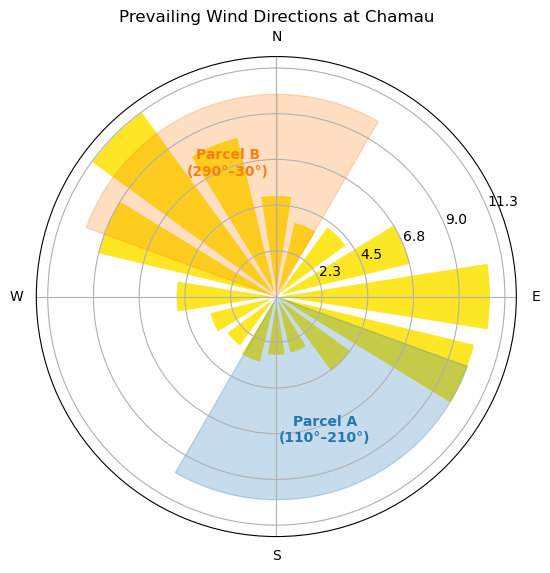

In [34]:
# WIND ROSE FIGURE

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from windrose import WindroseAxes

fig = plt.figure(figsize=(6, 6))
ax = WindroseAxes.from_ax(fig=fig)

# --- Base wind rose ---
ax.bar(df["WD"], np.ones(len(df)), normed=True, opening=0.8, edgecolor="white")
plt.title("Prevailing Wind Directions at Chamau")

# --- Highlight Parcel A (110°–210°) ---
theta_A = np.deg2rad(np.linspace(110, 210, 200))
ax.fill_between(theta_A, 0, 10, color="tab:blue", alpha=0.25, label="Parcel A")

# --- Highlight Parcel B (290°–360° and 0°–30°) ---
theta_B1 = np.deg2rad(np.linspace(290, 360, 100))
theta_B2 = np.deg2rad(np.linspace(0, 30, 100))
ax.fill_between(theta_B1, 0, 10, color="tab:orange", alpha=0.25, label="Parcel B")
ax.fill_between(theta_B2, 0, 10, color="tab:orange", alpha=0.25)

# --- Make North (0°) point upward and increase clockwise ---
ax.set_theta_zero_location("N")   # 0° at top
ax.set_theta_direction(-1)        # Clockwise angles

# --- Add cardinal directions ---
ax.set_thetagrids(angles=[0, 90, 180, 270], labels=["N", "E", "S", "W"])

# --- Legend + layout ---
ax.text(np.deg2rad(160), 7, "Parcel A\n(110°–210°)",
        ha="center", va="center", fontsize=10, color="tab:blue", weight="bold")

ax.text(np.deg2rad(340), 7, "Parcel B\n(290°–30°)",
        ha="center", va="center", fontsize=10, color="tab:orange", weight="bold")

plt.show()


In [42]:
len(chamau_lag)

15851

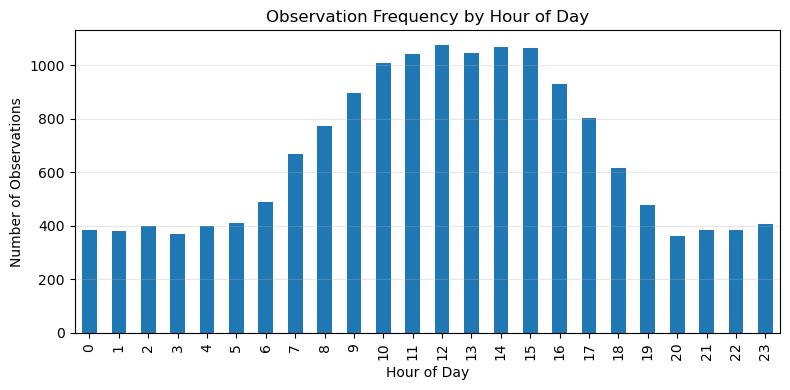

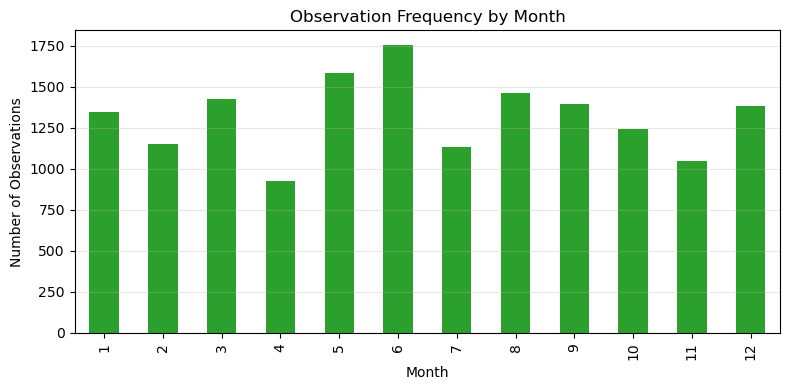

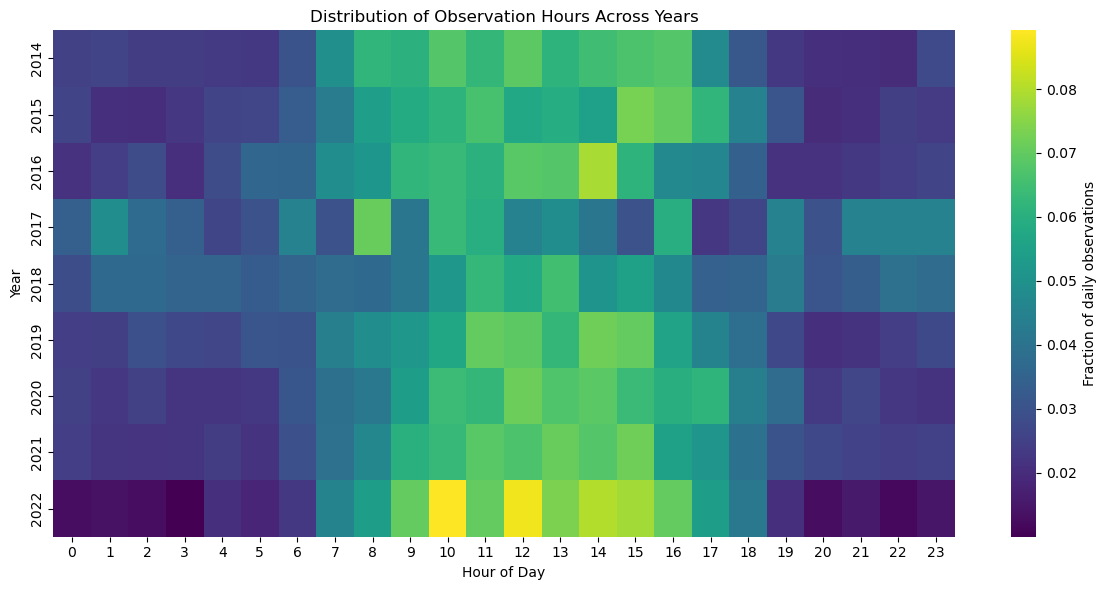

In [16]:
# count observations per hour
hourly_counts = chamau_lag["hour"].value_counts().sort_index()

# plot
plt.figure(figsize=(8,4))
hourly_counts.plot(kind="bar")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Observations")
plt.title("Observation Frequency by Hour of Day")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# count per month
monthly_counts = chamau_lag["month"].value_counts().sort_index()

# plot
plt.figure(figsize=(8,4))
monthly_counts.plot(kind="bar", color="tab:green")
plt.xlabel("Month")
plt.ylabel("Number of Observations")
plt.title("Observation Frequency by Month")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# group by year × hour
hour_year_counts = (
    chamau_lag.groupby(["year", "hour"])
    .size()
    .unstack(fill_value=0)
)

# normalize by total per year (to compare proportions)
hour_year_norm = hour_year_counts.div(hour_year_counts.sum(axis=1), axis=0)

# plot as heatmap
plt.figure(figsize=(12,6))
sns.heatmap(hour_year_norm, cmap="viridis", cbar_kws={"label": "Fraction of daily observations"})
plt.xlabel("Hour of Day")
plt.ylabel("Year")
plt.title("Distribution of Observation Hours Across Years")
plt.tight_layout()
plt.show()



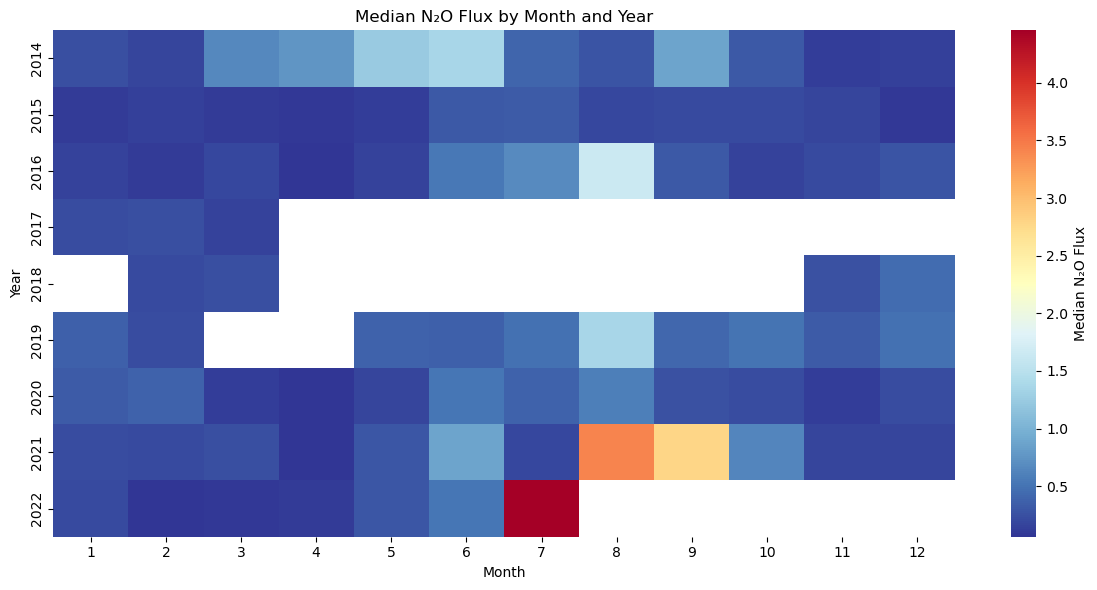

/tmp/ipykernel_3245468/1499290335.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chamau_lag.groupby(["T4_bin", "T15_bin"])["N2O_Flux"]


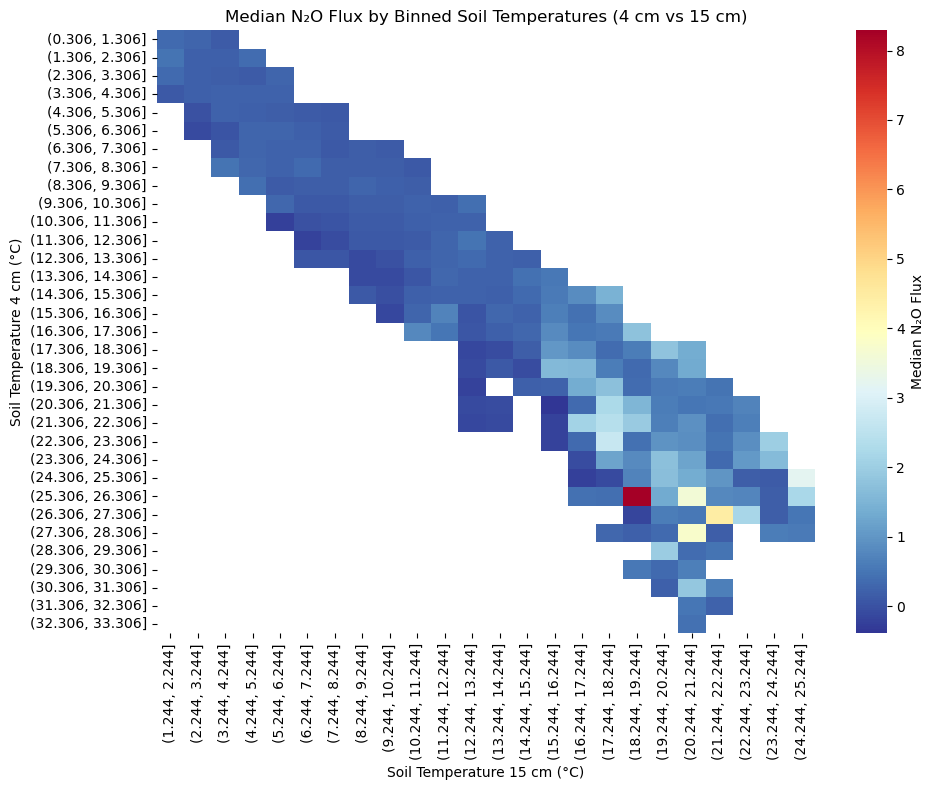

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# compute median N₂O flux per year × hour
median_flux = (
    chamau_lag.groupby(["year", "month"])["N2O_Flux"]
    .median()
    .unstack(fill_value=np.nan)
)

# plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(
    median_flux,
    cmap="RdYlBu_r",
    cbar_kws={"label": "Median N₂O Flux"},
)
plt.xlabel("Month")
plt.ylabel("Year")
plt.title("Median N₂O Flux by Month and Year")
plt.tight_layout()
plt.show()

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# define bin edges for both temperatures
bins_4cm = np.arange(chamau_lag["SoilTemp_4cm"].min(), chamau_lag["SoilTemp_4cm"].max()+1, 1)
bins_15cm = np.arange(chamau_lag["SoilTemp_15cm"].min(), chamau_lag["SoilTemp_15cm"].max()+1, 1)

# create binned categories
chamau_lag["T4_bin"] = pd.cut(chamau_lag["SoilTemp_4cm"], bins=bins_4cm)
chamau_lag["T15_bin"] = pd.cut(chamau_lag["SoilTemp_15cm"], bins=bins_15cm)

# compute median flux per 2D bin
median_flux_binned = (
    chamau_lag.groupby(["T4_bin", "T15_bin"])["N2O_Flux"]
    .median()
    .unstack(fill_value=np.nan)
)

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    median_flux_binned,
    cmap="RdYlBu_r",
    cbar_kws={"label": "Median N₂O Flux"},
)
plt.xlabel("Soil Temperature 15 cm (°C)")
plt.ylabel("Soil Temperature 4 cm (°C)")
plt.title("Median N₂O Flux by Binned Soil Temperatures (4 cm vs 15 cm)")
plt.tight_layout()
plt.show()

In [27]:
def plot_time_series(df, vars_to_plot):
    """
    Plot time series of selected variables, optionally averaged over a given frequency.
    """
    df = df.copy()
    df = df.sort_index()


    # --- Plot layout ---
    n_cols = 3
    n_rows = int(len(vars_to_plot) / n_cols) + (len(vars_to_plot) % n_cols > 0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12), sharex=True)
    axes = axes.flatten()

    # --- Plot each variable ---
    for i, var in enumerate(vars_to_plot):
        ax = axes[i]
        ax.plot(df.index, df[var], lw=1)
        ax.set_title(var, fontsize=10)
        ax.set_ylabel(var)
        ax.grid(True, alpha=0.3)

    # --- Remove empty subplots ---
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Time Series", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


Raw Data


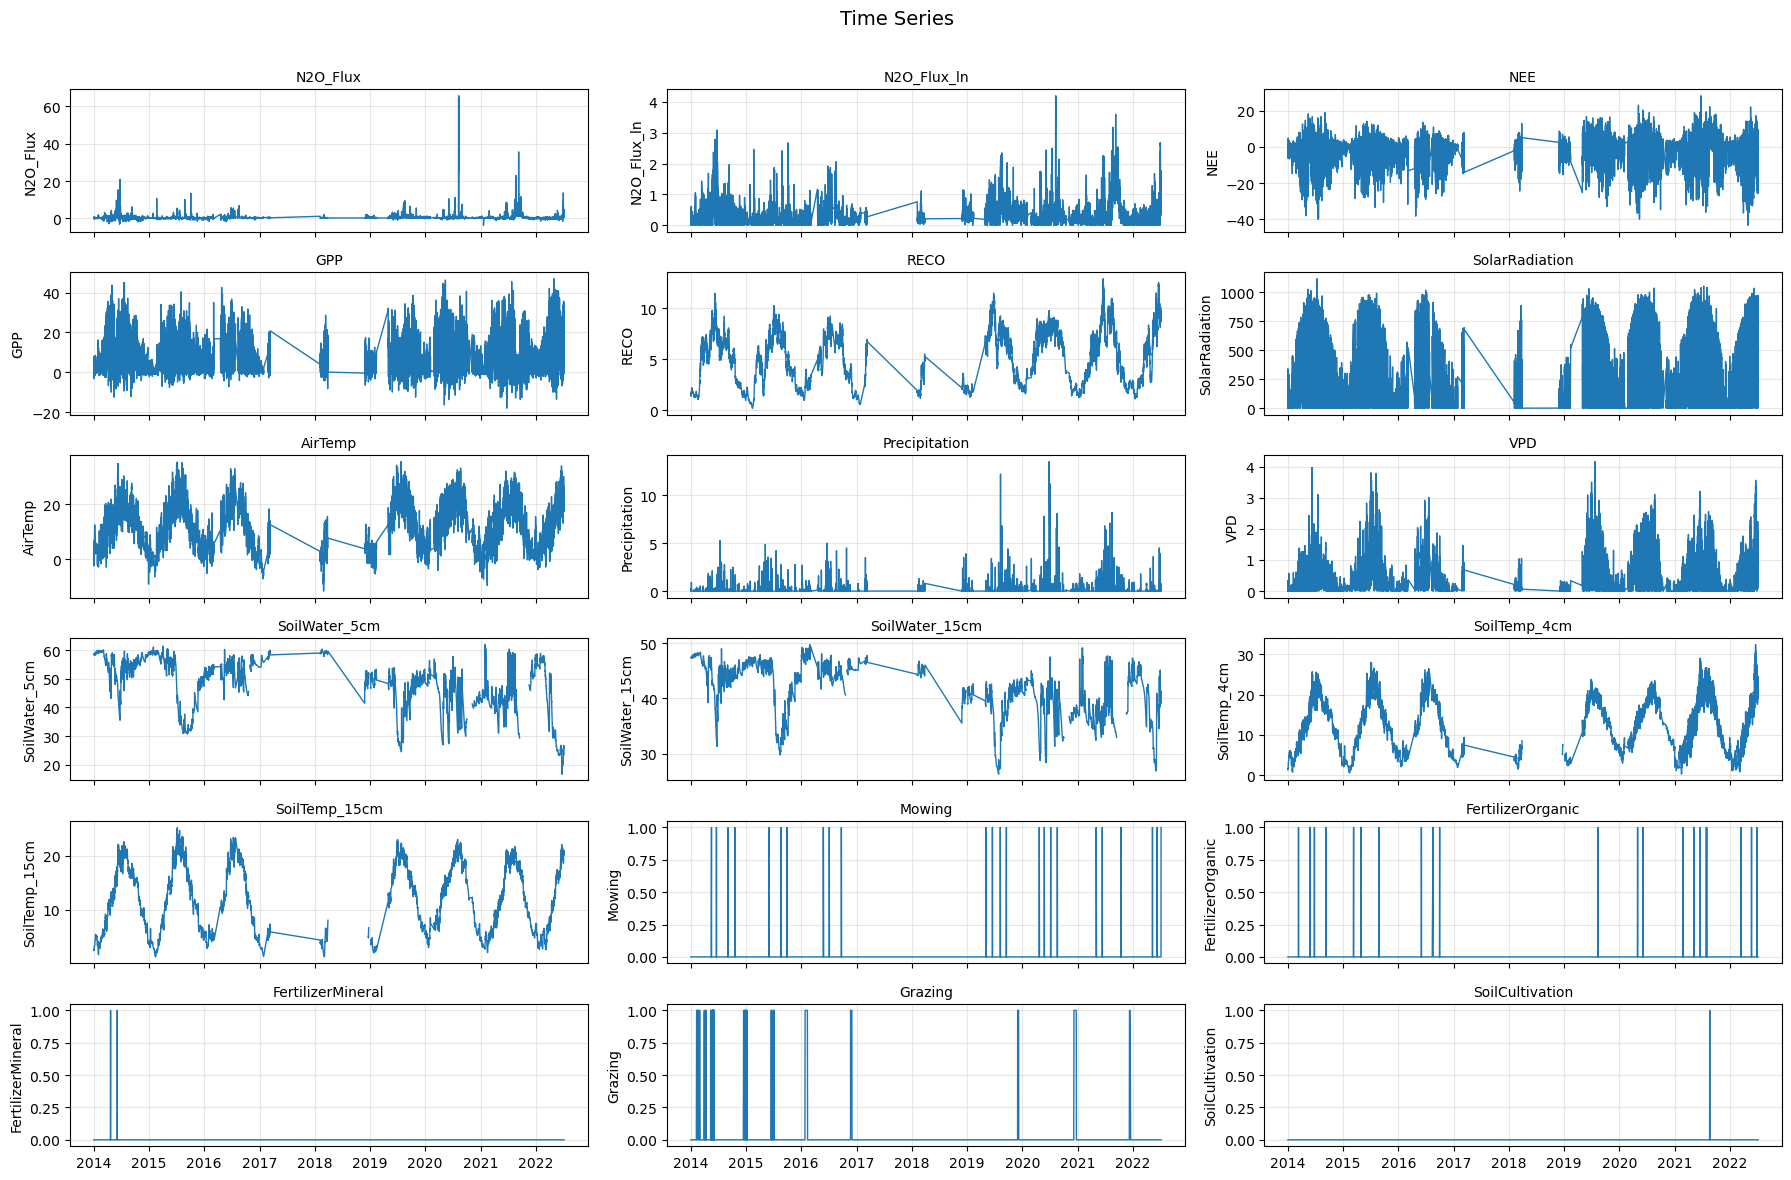

Daily Freq


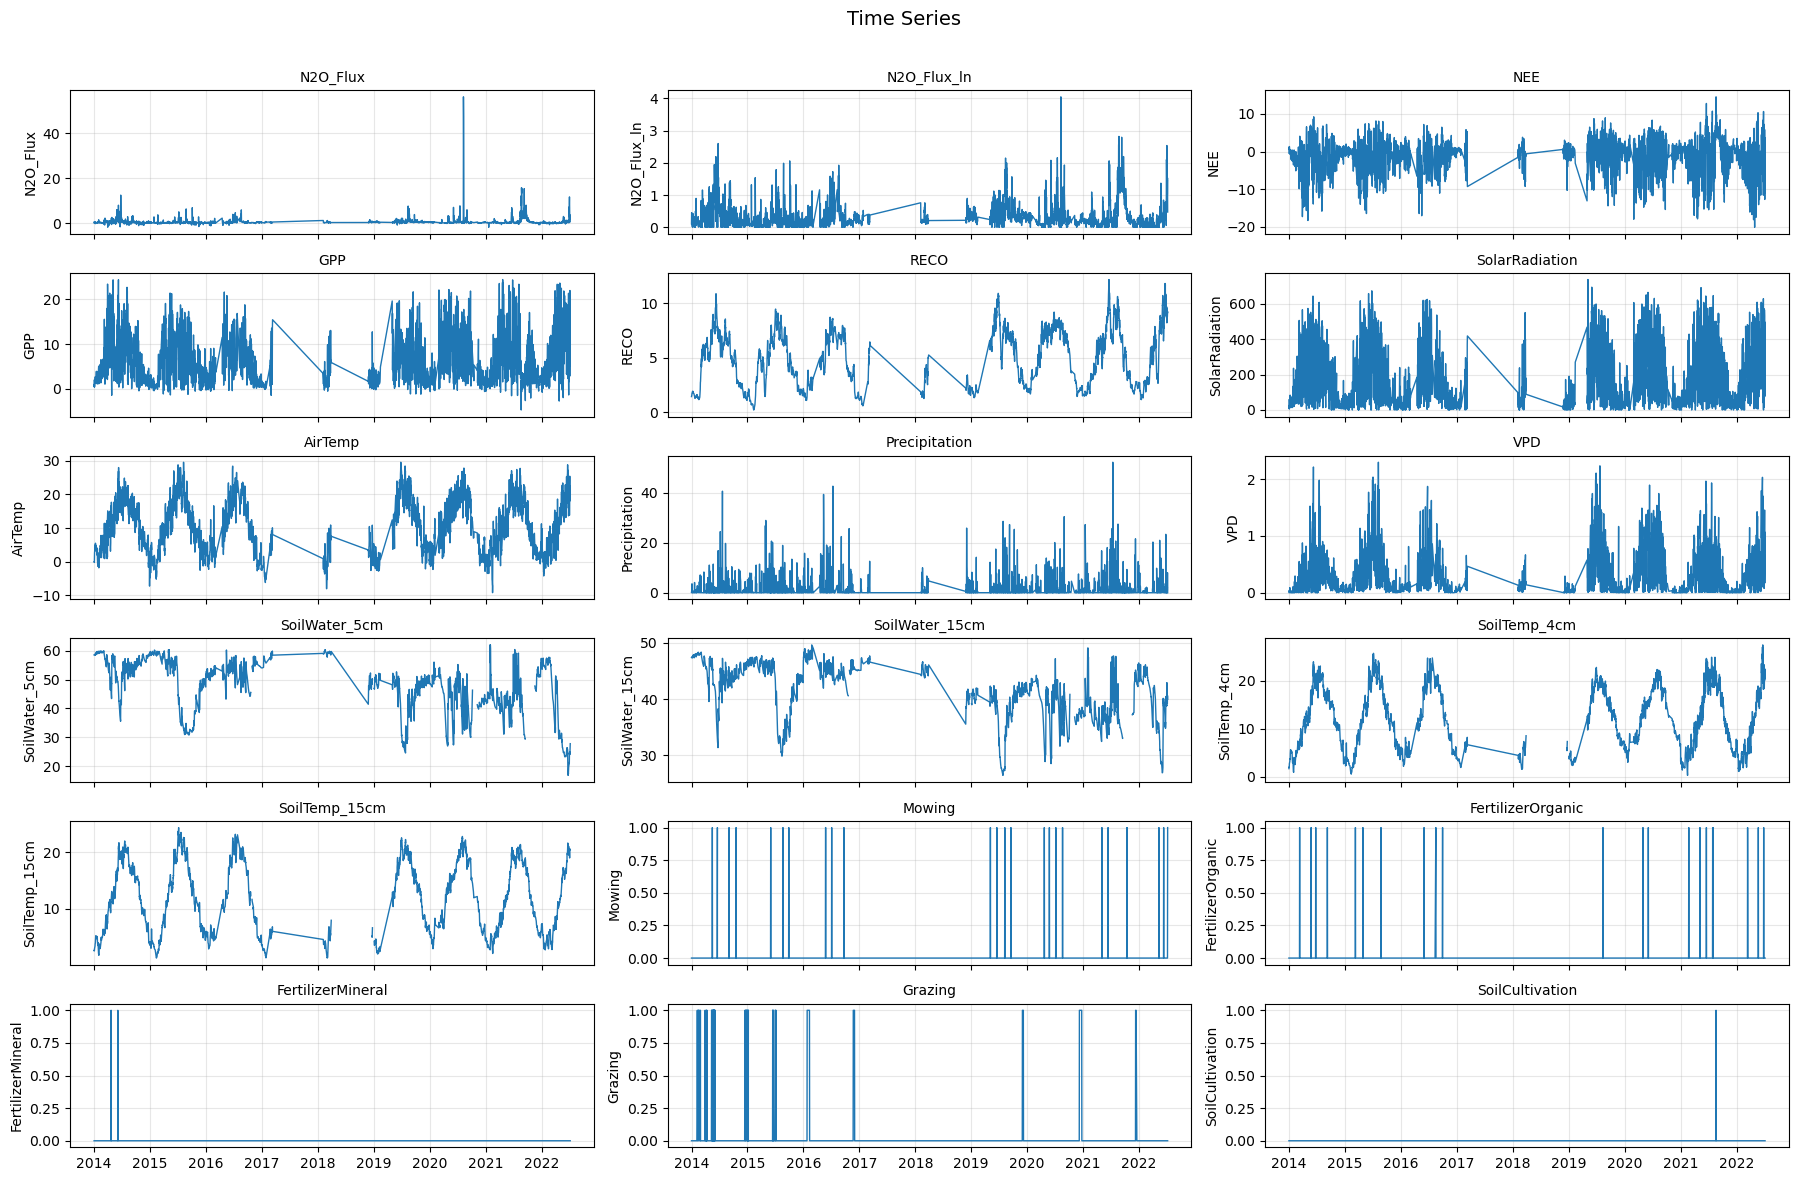

In [28]:
vars_to_plot = [
    "N2O_Flux", "N2O_Flux_ln", "NEE", "GPP", "RECO",
    "SolarRadiation", "AirTemp", "Precipitation",
    "VPD", "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"
]

# Daily averages
print("Raw Data")
plot_time_series(chamau_lag, vars_to_plot)
print("Daily Freq")
plot_time_series(chamau_daily, vars_to_plot)

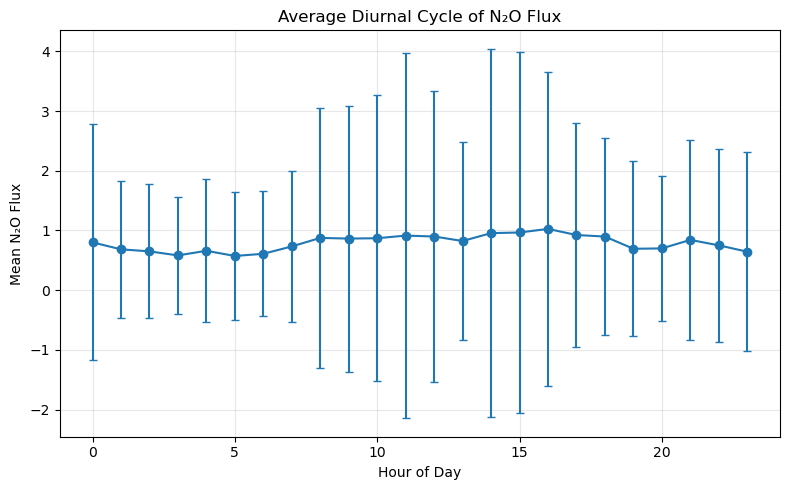

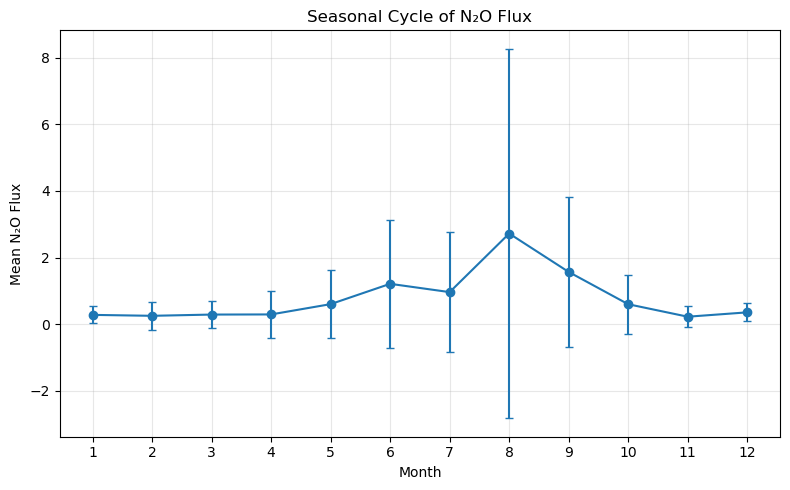

In [30]:
hourly_mean = chamau_lag.groupby("hour")["N2O_Flux"].mean()
hourly_std  = chamau_lag.groupby("hour")["N2O_Flux"].std()

plt.figure(figsize=(8, 5))
plt.errorbar(hourly_mean.index, hourly_mean, yerr=hourly_std, fmt="-o", capsize=3)
plt.xlabel("Hour of Day")
plt.ylabel("Mean N₂O Flux")
plt.title("Average Diurnal Cycle of N₂O Flux")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

monthly_mean = chamau_lag.groupby("month")["N2O_Flux"].mean()
monthly_std  = chamau_lag.groupby("month")["N2O_Flux"].std()

plt.figure(figsize=(8, 5))
plt.errorbar(monthly_mean.index, monthly_mean, yerr=monthly_std, fmt="-o", capsize=3)
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Mean N₂O Flux")
plt.title("Seasonal Cycle of N₂O Flux")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



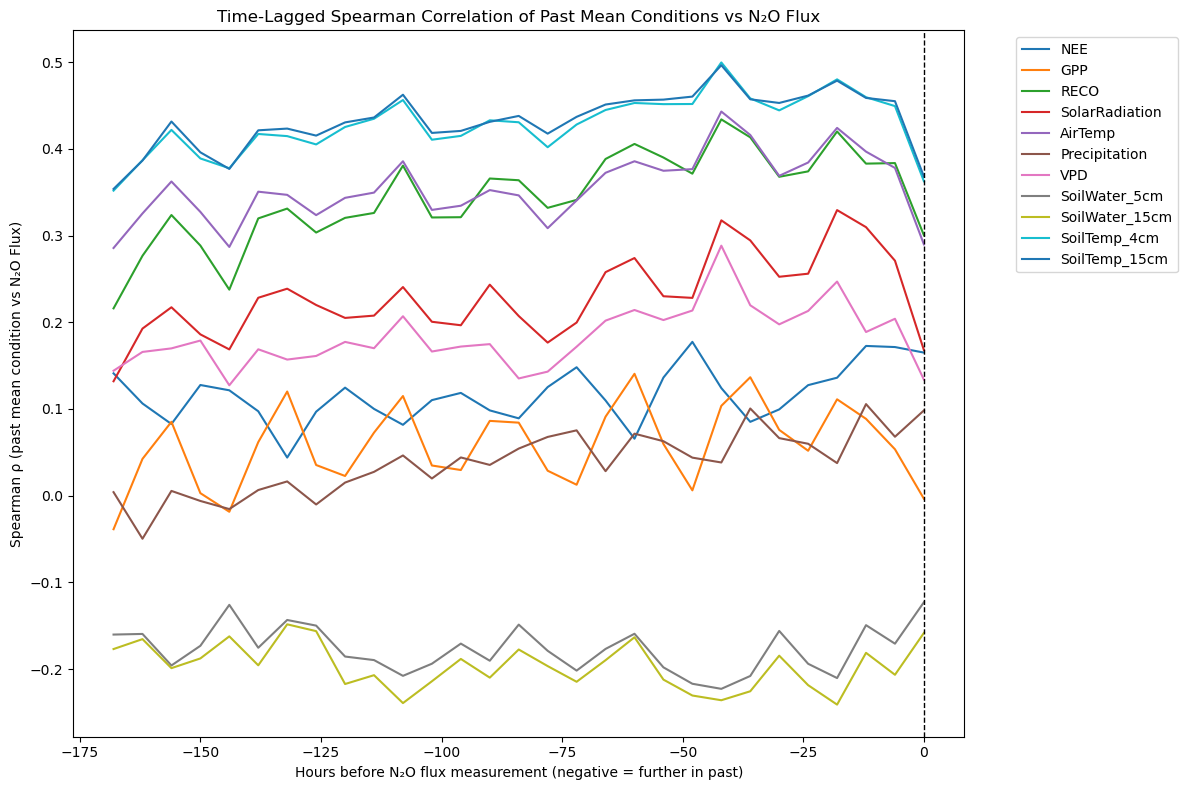

In [31]:
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Base setup ---
chamau_time_index = chamau_lag.copy()

predictors = [
    "NEE", "GPP", "RECO",
    "SolarRadiation", "AirTemp", "Precipitation", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
]

target = "N2O_Flux"

# --- Parameters ---
window_hours = 24        # window size for averaging (past 24h)
step_hours   = 6        # step between lags
max_hours    = 7 * 24    # look back 1 week (you can extend to 5 weeks)
offsets      = range(0, -max_hours - step_hours, -step_hours)  # only past (0, -24, -48, ...)

# --- Rolling mean of predictors (24h backward window) ---
window = f"{window_hours}h"
rolling_means = chamau_time_index[predictors].rolling(window=window, closed="left").mean()

# --- Compute lag correlations (Spearman) ---
lag_corrs = {}

for var in predictors:
    corrs = []
    for offset in offsets:
        shifted = rolling_means[var].shift(freq=pd.Timedelta(hours=offset))
        aligned = chamau_time_index[[target]].join(shifted.rename("past_mean")).dropna()
        if len(aligned) > 2:
            rho, _ = spearmanr(aligned[target], aligned["past_mean"])
            corrs.append(rho)
        else:
            corrs.append(np.nan)
    lag_corrs[var] = (list(offsets), corrs)

# --- Plot results ---
plt.figure(figsize=(12, 8))
for var, (offsets, corrs) in lag_corrs.items():
    plt.plot(offsets, corrs, label=var)

plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("Hours before N₂O flux measurement (negative = further in past)")
plt.ylabel("Spearman ρ (past mean condition vs N₂O Flux)")
plt.title("Time-Lagged Spearman Correlation of Past Mean Conditions vs N₂O Flux")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


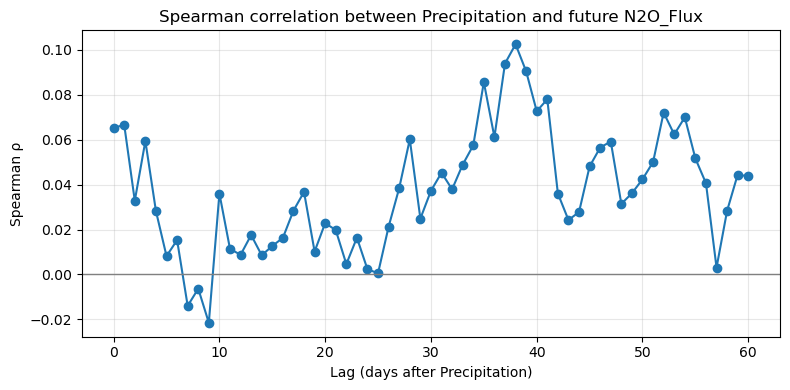

Peak Spearman correlation at lag = 38 days (ρ = 0.102)


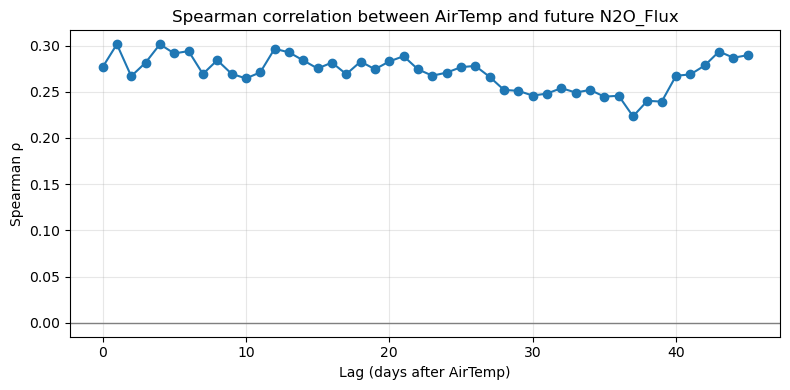

Peak Spearman correlation at lag = 1 days (ρ = 0.301)


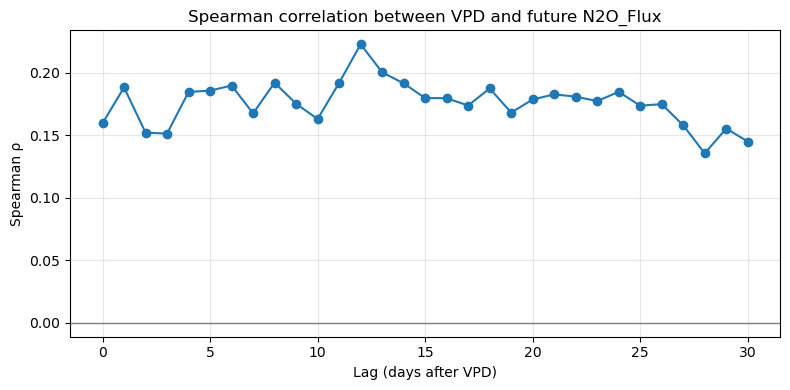

Peak Spearman correlation at lag = 12 days (ρ = 0.223)


In [38]:
from scipy.stats import spearmanr

def plot_lag_correlation(df, col, target="N2O_Flux", max_lag=60, resample_daily=True):
    """
    Compute and plot the Spearman correlation between a predictor and target variable
    over increasing day lags (calendar-based).

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with a DatetimeIndex.
    col : str
        Column name of the predictor variable (e.g. "Precipitation").
    target : str, optional
        Column name of the target variable, by default "N2O_Flux".
    max_lag : int, optional
        Maximum lag in days, by default 60.
    resample_daily : bool, optional
        If True, resample to daily mean (useful if data is sub-daily).

    Returns
    -------
    pd.DataFrame
        DataFrame with 'lag' and 'spearman_r' for each lag.
    """

    # --- Ensure datetime index ---
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # --- Optional daily resampling ---
    if resample_daily:
        df = df.select_dtypes(include=[np.number]).resample("D").mean()

    # --- Filter for valid positive flux values ---
    df = df[df[target] >= 0][[col, target]].dropna(subset=[target])

    # --- Compute lag correlations ---
    lags = np.arange(0, max_lag + 1)
    corrs = []

    for lag in lags:
        shifted = df[col].shift(freq=pd.to_timedelta(lag, unit="D"))
        aligned = pd.concat([df[target], shifted], axis=1, join="inner").dropna()

        if aligned.empty:
            corrs.append(np.nan)
        else:
            r, _ = spearmanr(aligned[target], aligned[col])
            corrs.append(r)

    # --- Store results ---
    result = pd.DataFrame({"lag_days": lags, "spearman_r": corrs})

    # --- Plot ---
    plt.figure(figsize=(8, 4))
    plt.plot(result["lag_days"], result["spearman_r"], marker="o", color="tab:blue")
    plt.axhline(0, color="gray", lw=1)
    plt.xlabel(f"Lag (days after {col})")
    plt.ylabel("Spearman ρ")
    plt.title(f"Spearman correlation between {col} and future {target}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Report peak correlation ---
    best_lag = result["lag_days"].iloc[np.nanargmax(result["spearman_r"])]
    best_r = np.nanmax(result["spearman_r"])
    print(f"Peak Spearman correlation at lag = {best_lag} days (ρ = {best_r:.3f})")

plot_lag_correlation(chamau_lag, col="Precipitation", max_lag=60)
plot_lag_correlation(chamau_lag, col="AirTemp", max_lag=45)
plot_lag_correlation(chamau_lag, col="VPD", max_lag=30)

In [56]:
def cross_correlation_per_parcel(df, predictor_vars, target="N2O_Flux", max_lag=60):
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"])
            df = df.set_index("Date")
        else:
            raise ValueError("DataFrame must have a DatetimeIndex or 'Date' column")

    df = df[df[target] >= 0].dropna(subset=[target])
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    predictor_vars = [v for v in predictor_vars if v in numeric_cols]
    lags = np.arange(-max_lag, max_lag + 1)
    parcels = df["Parcel"].unique()
    results_dict = {}

    fig, axes = plt.subplots(1, len(parcels), figsize=(14, 5), sharey=True)
    if len(parcels) == 1:
        axes = [axes]

    for ax, parcel in zip(axes, parcels):
        sub = df[df["Parcel"] == parcel].copy().sort_index()
        corrs_dict = {}

        for var in predictor_vars:
            corrs = []
            for lag in lags:
                shifted = sub[var].shift(freq=pd.to_timedelta(lag, unit="D"))
                aligned = pd.concat([sub[target], shifted], axis=1, join="inner").dropna()
                rho = np.nan if aligned.empty else spearmanr(aligned[target], aligned[var])[0]
                corrs.append(rho)
            corrs_dict[var] = corrs

        for var, corrs in corrs_dict.items():
            ax.plot(lags, corrs, lw=1.2, label=var)

        ax.axhline(0, color="gray", lw=1)
        ax.axvline(0, color="gray", lw=1, ls="--")
        ax.set_xlabel("Lag (days)")
        ax.set_title(f"Parcel {parcel}")
        ax.grid(True, alpha=0.3)
        results_dict[parcel] = corrs_dict

    axes[0].set_ylabel("Spearman ρ")
    fig.suptitle("Cross-correlation between predictors and N₂O flux (per parcel)", fontsize=13)
    fig.legend(predictor_vars, loc="upper center", ncol=3, fontsize=9)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

    # --- Summary ---
    summary_rows = []
    for parcel in parcels:
        for var, corrs in results_dict[parcel].items():
            best_idx = np.nanargmax(np.abs(corrs))
            summary_rows.append({
                "Parcel": parcel,
                "Variable": var,
                "Best lag (days)": int(lags[best_idx]),
                "Max corr (ρ)": corrs[best_idx],
            })

    summary_df = pd.DataFrame(summary_rows)
    summary_df = (
        summary_df
        .sort_values(
            by=["Parcel", "Max corr (ρ)"],
            ascending=[True, False],
            key=lambda col: np.abs(col) if col.name == "Max corr (ρ)" else col
        )
        .round(3)
    )

    return summary_df

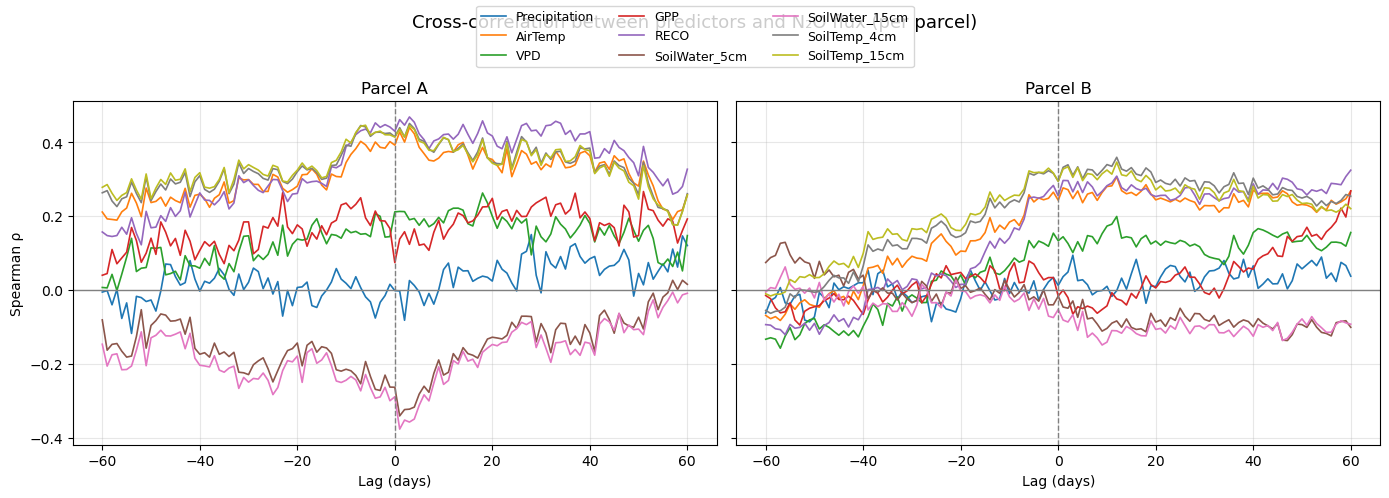

   Parcel        Variable  Best lag (days)  Max corr (ρ)
4       A            RECO                3         0.469
7       A    SoilTemp_4cm                3         0.451
8       A   SoilTemp_15cm               -6         0.446
1       A         AirTemp                3         0.440
6       A  SoilWater_15cm                1        -0.376
5       A   SoilWater_5cm                1        -0.340
3       A             GPP               51         0.267
2       A             VPD               18         0.263
0       A   Precipitation               28         0.150
16      B    SoilTemp_4cm               12         0.359
17      B   SoilTemp_15cm               12         0.346
13      B            RECO               60         0.325
10      B         AirTemp               12         0.306
12      B             GPP               60         0.269
11      B             VPD               12         0.199
15      B  SoilWater_15cm                9        -0.148
14      B   SoilWater_5cm      

In [57]:
predictors = [
    "Precipitation", "AirTemp", "VPD", "GPP", "RECO",
    "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm"
]

summary = cross_correlation_per_parcel(chamau_daily, predictor_vars=predictors, max_lag=60)
print(summary)


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

def train_rf_timeseries(df, predictors, target,
                        test_size=0.3, n_estimators=300, random_state=42, plot=True):
    """
    Train a Random Forest on time-series data using a chronological split.
    """

    # --- ensure time order ---
    df = df.sort_index().copy()

    # --- extract features/target ---
    X = df[predictors]
    y = df[target]

    # --- handle NaNs ---
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]

    # --- offset for positivity ---
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset

    # --- chronological split ---
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]


    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test  = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")

    # --- train model ---
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X_train, y_train)

    # --- predictions ---
    y_pred = rf.predict(X_test)

    # revert offset
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset

    # --- evaluation ---
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)

    # --- feature importance ---
    importances = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)

    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")

    # --- plot ---
    if plot:
        plt.figure(figsize=(6, 5))
        plt.scatter(y_test_lin, y_pred_lin, alpha=0.6)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        plt.plot([min_val, max_val], [min_val, max_val], "r--")
        plt.xlabel("Observed N₂O Flux")
        plt.ylabel("Predicted N₂O Flux")
        plt.title(f"Chronological RF (R²={r2:.2f}, ρ={rho:.2f})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        "model": rf,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
    }


In [10]:
import pandas as pd

# --- Define predictor groups ---
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral",
        "Grazing", "SoilCultivation"
    ],

    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",

        # Meteorological lag variables
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # Management and days since management
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_Grazing", "DaysSince_SoilCultivation"
    ],

    "main": [
        "AirTemp", "VPD",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "RECO", "SolarRadiation"
    ]
}

# --- Define datasets (includes split daily A/B) ---
datasets = {
    "Hourly (chamau_lag)": chamau_lag,
    "Daily A": chamau_daily_A,
    "Daily B": chamau_daily_B
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

# --- Run training loop ---
results_summary = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, predictors in predictor_sets.items():
            print(f"\n--- Training on {df_name} | target={target} | predictors={set_name} ---")
            try:
                res = train_rf_timeseries(
                    df=df,
                    predictors=predictors,
                    target=target,
                    plot=False  # suppress plotting
                )
                results_summary.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictor_Set": set_name,
                    "R²": res["r2"],
                    "Spearman_ρ": res["spearman_rho"]
                })
            except Exception as e:
                print(f"Skipped {df_name} | {target} | {set_name} due to error: {e}")
                results_summary.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictor_Set": set_name,
                    "R²": None,
                    "Spearman_ρ": None
                })

# --- Combine results ---
results_df = pd.DataFrame(results_summary).round(3)
print("\n=== Summary Results ===")
display(results_df)



--- Training on Hourly (chamau_lag) | target=N2O_Flux | predictors=base ---
Train period: 2014-01-01 08:15:00 → 2020-07-18 15:45:00
Test  period: 2020-07-19 10:15:00 → 2022-07-06 09:15:00

Model evaluation:
  R² (linear scale): -0.019
  Spearman ρ:        0.417

--- Training on Hourly (chamau_lag) | target=N2O_Flux | predictors=lag ---
Train period: 2014-01-01 08:15:00 → 2015-10-10 15:15:00
Test  period: 2015-10-11 08:45:00 → 2022-07-06 09:15:00

Model evaluation:
  R² (linear scale): -0.160
  Spearman ρ:        0.319

--- Training on Hourly (chamau_lag) | target=N2O_Flux | predictors=main ---
Train period: 2014-01-01 08:15:00 → 2020-09-23 17:15:00
Test  period: 2020-09-24 03:45:00 → 2022-07-06 09:15:00

Model evaluation:
  R² (linear scale): 0.037
  Spearman ρ:        0.374

--- Training on Hourly (chamau_lag) | target=N2O_Flux_ln | predictors=base ---
Train period: 2014-01-01 08:15:00 → 2020-07-18 15:45:00
Test  period: 2020-07-19 10:15:00 → 2022-07-06 09:15:00

Model evaluation:
  

Dataset       Target Predictor_Set     R²  Spearman_ρ
0   Hourly (chamau_lag)     N2O_Flux          base -0.019       0.417
1   Hourly (chamau_lag)     N2O_Flux           lag -0.160       0.319
2   Hourly (chamau_lag)     N2O_Flux          main  0.037       0.374
3   Hourly (chamau_lag)  N2O_Flux_ln          base  0.075       0.397
4   Hourly (chamau_lag)  N2O_Flux_ln           lag -0.038       0.349
5   Hourly (chamau_lag)  N2O_Flux_ln          main  0.081       0.330
6               Daily A     N2O_Flux          base  0.098       0.439
7               Daily A     N2O_Flux           lag  0.134       0.518
8               Daily A     N2O_Flux          main  0.112       0.303
9               Daily A  N2O_Flux_ln          base  0.194       0.460
10              Daily A  N2O_Flux_ln           lag  0.283       0.528
11              Daily A  N2O_Flux_ln          main  0.157       0.305
12              Daily B     N2O_Flux          base  0.003       0.449
13              Daily B     N2O_Flux           lag  0.006       0.521
14              Daily B     N2O_Flux          main -0.016       0.341
15              Daily B  N2O_Flux_ln          base  0.166       0.510
16              Daily B  N2O_Flux_ln           lag  0.156       0.523
17              Daily B  N2O_Flux_ln          main  0.124       0.347

--- Training on chamau_daily | target=N2O_Flux_ln | predictors=lag ---
Train period: 2014-01-01 00:00:00 → 2019-10-20 00:00:00
Test  period: 2019-10-21 00:00:00 → 2022-07-06 00:00:00

Model evaluation:
  R² (linear scale): 0.274
  Spearman ρ:        0.557


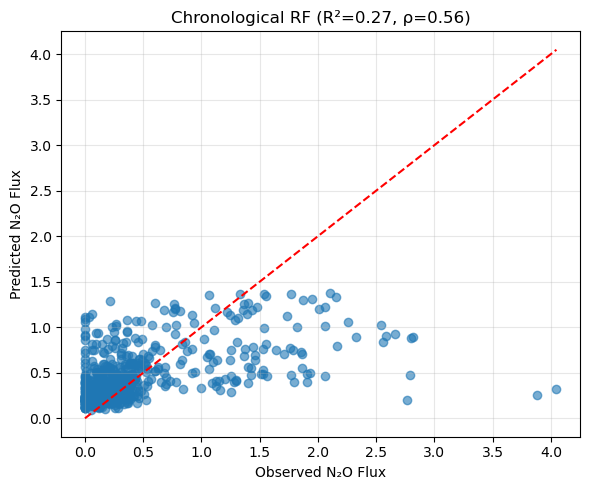

main cols
Train period: 2014-01-01 08:15:00 → 2020-09-23 17:15:00
Test  period: 2020-09-24 03:45:00 → 2022-07-06 09:15:00

Model evaluation:
  R² (linear scale): 0.081
  Spearman ρ:        0.330


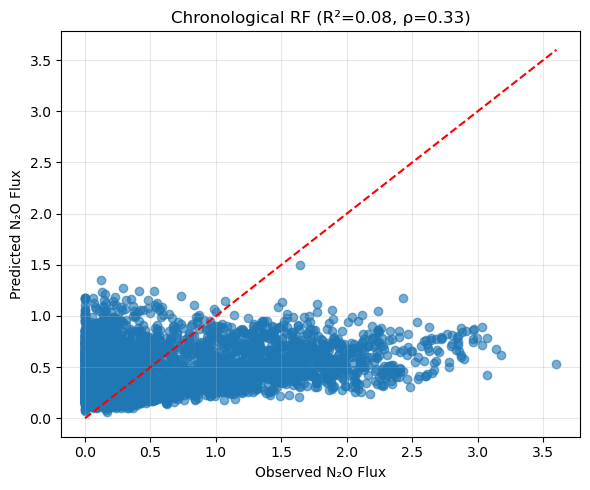

In [73]:
# --- Training on chamau_daily | target=N2O_Flux_ln | predictors=lag ---
print("--- Training on chamau_daily | target=N2O_Flux_ln | predictors=lag ---")

results = train_rf_timeseries(
    df=chamau_daily,
    predictors=[
        # --- Meteorological base variables ---
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",

        # --- Meteorological lag variables ---
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # --- Management variables ---
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",

        # --- Days since management events ---
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_Grazing", "DaysSince_SoilCultivation"
    ],
    target="N2O_Flux_ln",
)
  

print("main cols")
results = train_rf_timeseries(
    df=chamau_lag,
    predictors=[
    "AirTemp", "VPD",
    "SoilTemp_4cm", "SoilTemp_15cm",
     "RECO", "SolarRadiation"
    ],
    target="N2O_Flux_ln",
)

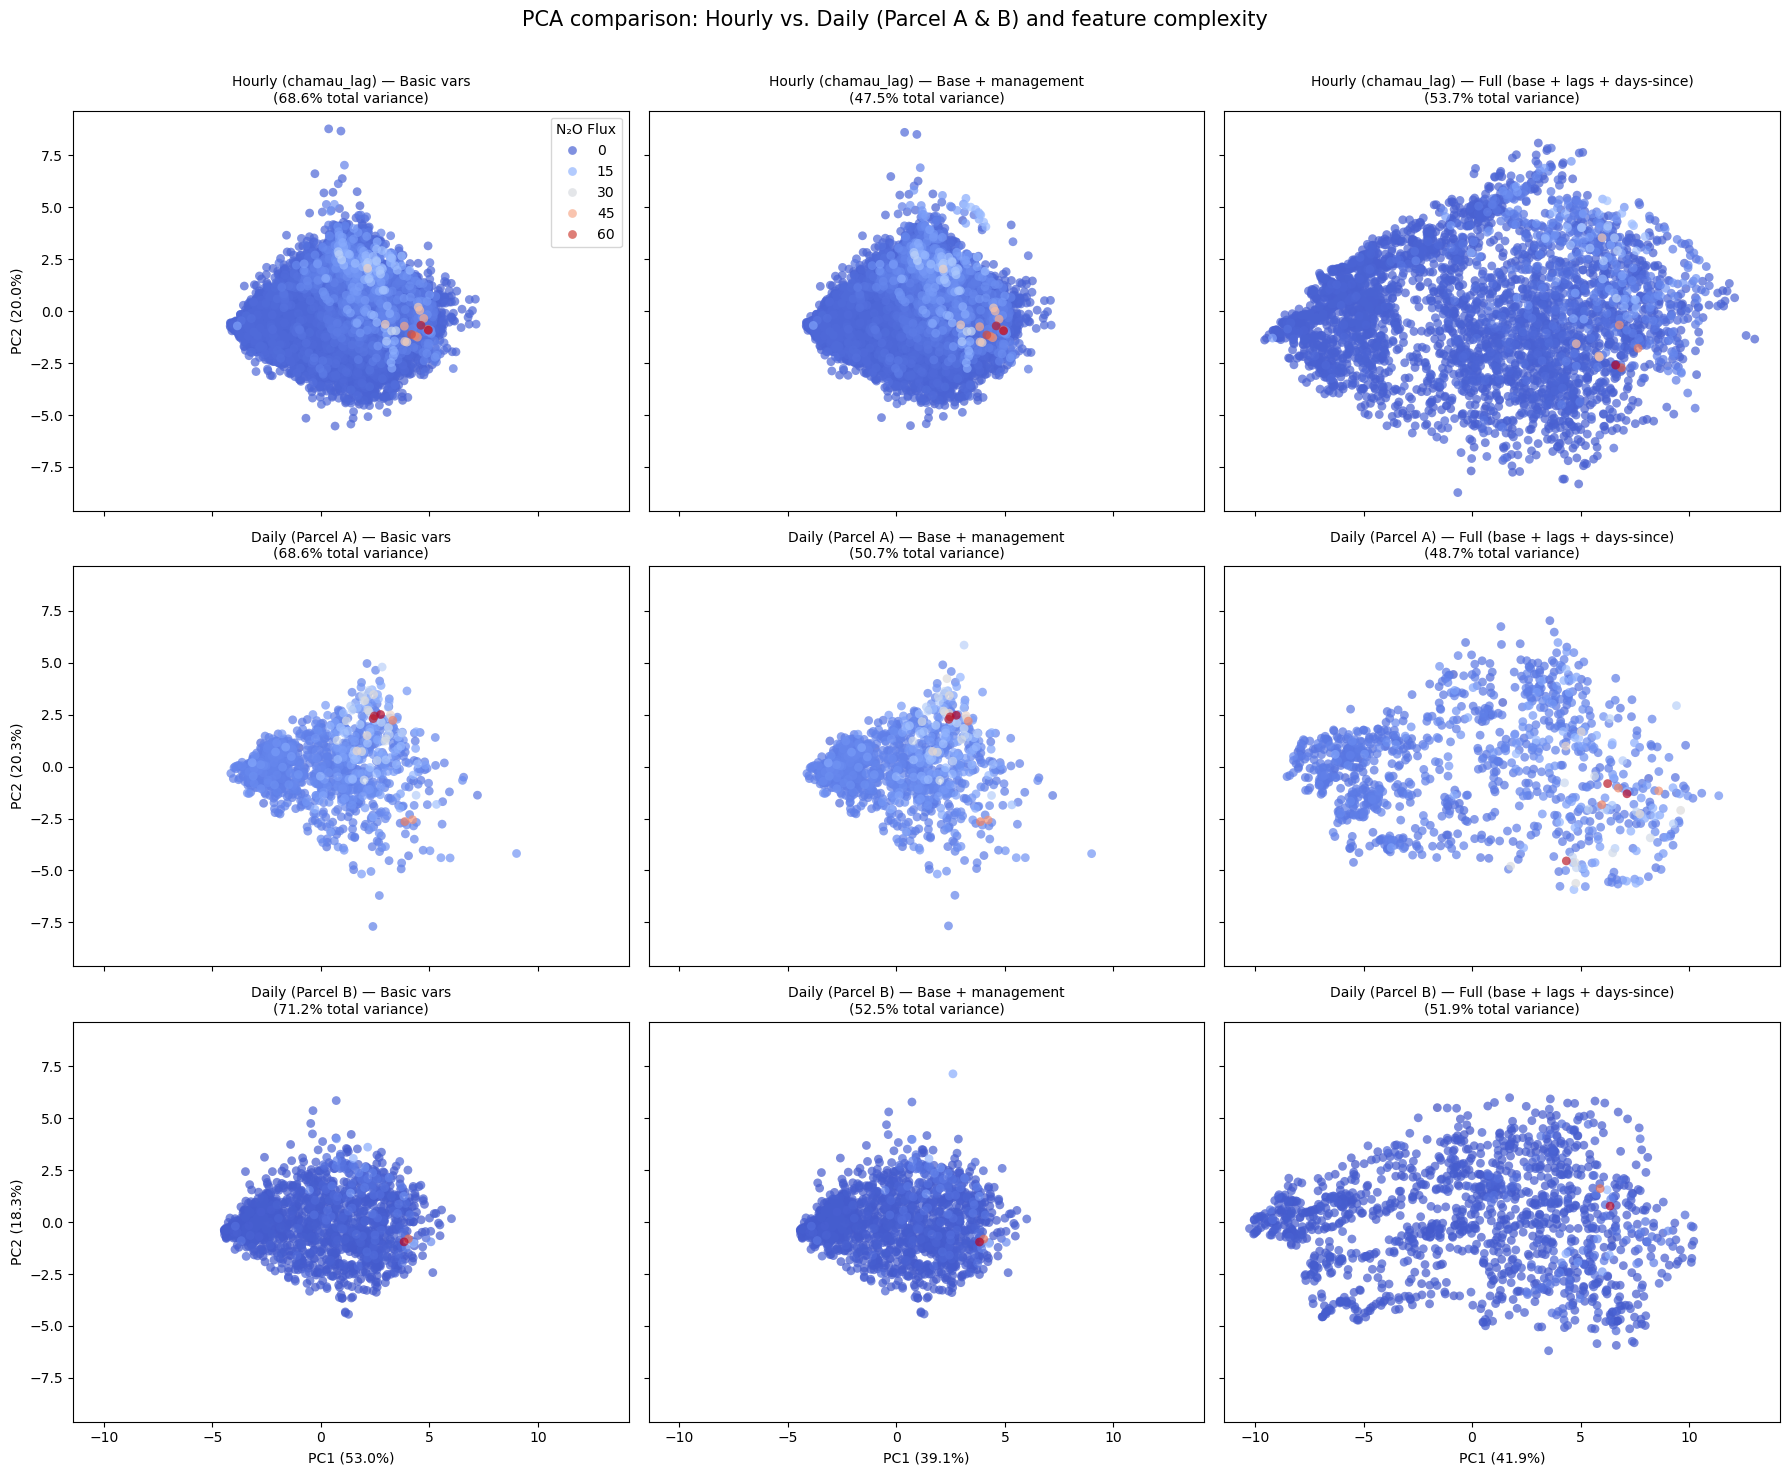

In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------
# Helper function — drop NaNs, sort by flux
# ---------------------------------

def run_pca(df, predictors, target="N2O_Flux", title="Dataset"):
    """
    Runs PCA on the given DataFrame and returns a DataFrame with PC1, PC2, and target variable.
    Drops rows with NaNs and sorts by target for visual clarity.
    """
    df = df.dropna(subset=[target]).copy()
    df = df.sort_values(by=target)

    X = df[predictors].select_dtypes(include=[np.number]).dropna()
    y = df.loc[X.index, target]

    if len(X) == 0:
        raise ValueError(f"{title}: No valid rows after dropping NaNs.")

    X_scaled = StandardScaler().fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=X.index)
    pca_df[target] = y
    return pca_df, pca


# ---------------------------------
# Feature sets
# ---------------------------------

base_vars = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
    "NEE", "GPP", "RECO"
]

base_plus_mgmt = base_vars + [
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"
]

lag_vars = base_plus_mgmt + [
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_Grazing", "DaysSince_SoilCultivation"
]

feature_sets = {
    "Basic vars": base_vars,
    "Base + management": base_plus_mgmt,
    "Full (base + lags + days-since)": lag_vars
}

# ---------------------------------
# Run PCA on all 3 datasets
# ---------------------------------

datasets = {
    "Hourly (chamau_lag)": chamau_lag,
    "Daily (Parcel A)": chamau_daily_A,
    "Daily (Parcel B)": chamau_daily_B
}

results = {}

for dname, df in datasets.items():
    for fname, feats in feature_sets.items():
        key = f"{dname} — {fname}"
        try:
            results[key] = run_pca(df, feats, title=key)
        except Exception as e:
            print(f"Skipped {key}: {e}")

# ---------------------------------
# Plot 3×3 PCA comparison
# ---------------------------------

fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharex=True, sharey=True)
axes = axes.flatten()

for i, (key, (pca_df, pca)) in enumerate(results.items()):
    ax = axes[i]
    sns.scatterplot(
        data=pca_df,
        x="PC1", y="PC2", hue="N2O_Flux",
        palette="coolwarm", ax=ax, s=40, alpha=0.7, edgecolor="none"
    )
    ax.set_title(f"{key}\n({pca.explained_variance_ratio_.sum()*100:.1f}% total variance)", fontsize=10)
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    if i == 0:
        ax.legend(title="N₂O Flux", loc="best")
    else:
        ax.get_legend().remove()

plt.suptitle("PCA comparison: Hourly vs. Daily (Parcel A & B) and feature complexity", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [15]:
loadings = pd.DataFrame(
    pca_lag.components_.T,
    index=X.columns,
    columns=["PC1", "PC2"]
)
print(loadings.sort_values("PC1", ascending=False))

                          PC1       PC2
RECO_lag3d           0.179940  0.034153
RECO_lag5d           0.179472  0.038103
SoilTemp_4cm         0.179310  0.049892
RECO_lag1d           0.178936  0.029040
SoilTemp_4cm_lag1d   0.178841  0.053908
...                       ...       ...
SoilWater_5cm_lag7d -0.112145 -0.163423
SoilWater_5cm_lag5d -0.115175 -0.166259
SoilWater_5cm       -0.115642 -0.142447
SoilWater_5cm_lag1d -0.116461 -0.155667
SoilWater_5cm_lag3d -0.116942 -0.163833

[68 rows x 2 columns]


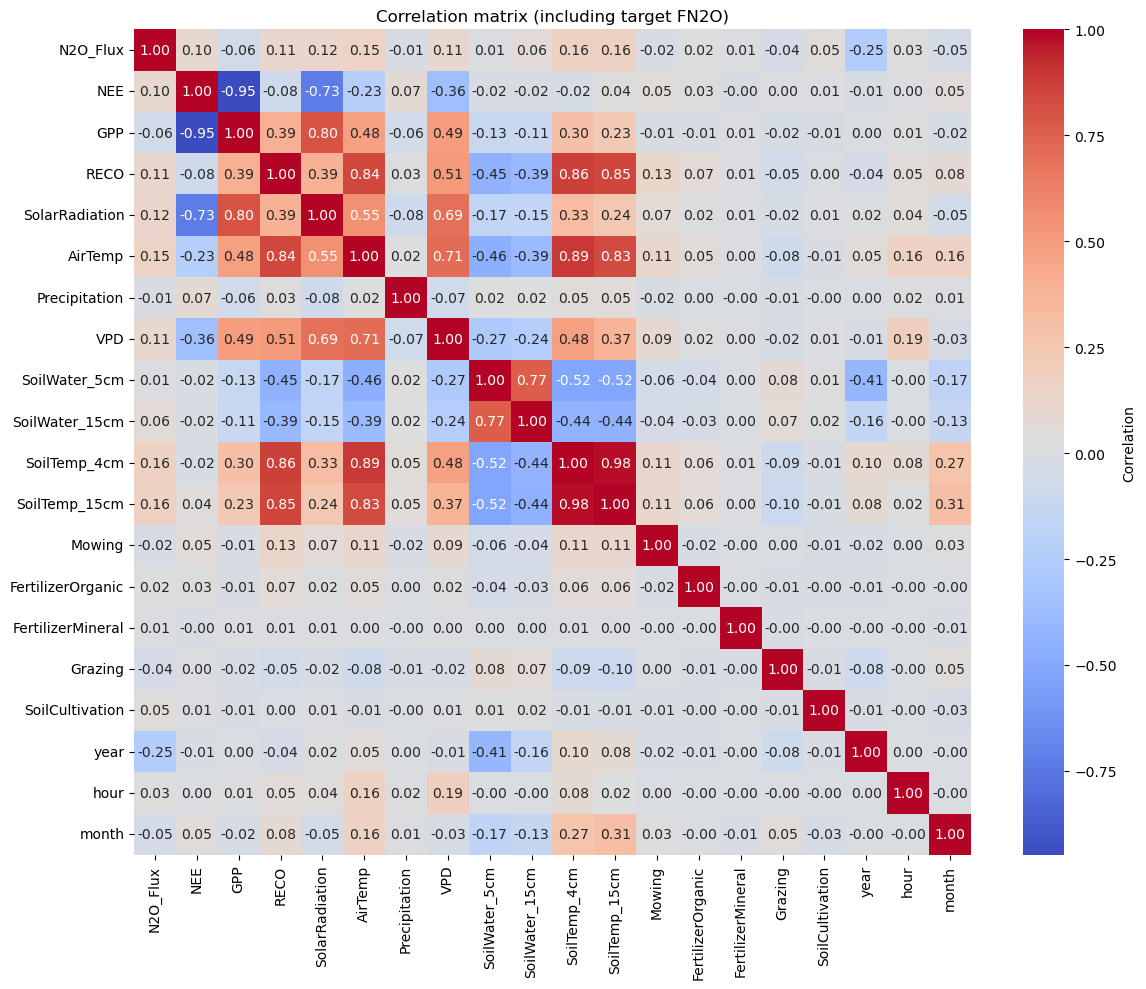

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (Pearson by default)
corr = chamau.corr(numeric_only=True)

plt.figure(figsize=(12,10))
sns.heatmap(
    corr, 
    annot=True, fmt=".2f", cmap="coolwarm",
    cbar_kws={'label': 'Correlation'}
)
plt.title("Correlation matrix (including target FN2O)")
plt.tight_layout()
plt.show()

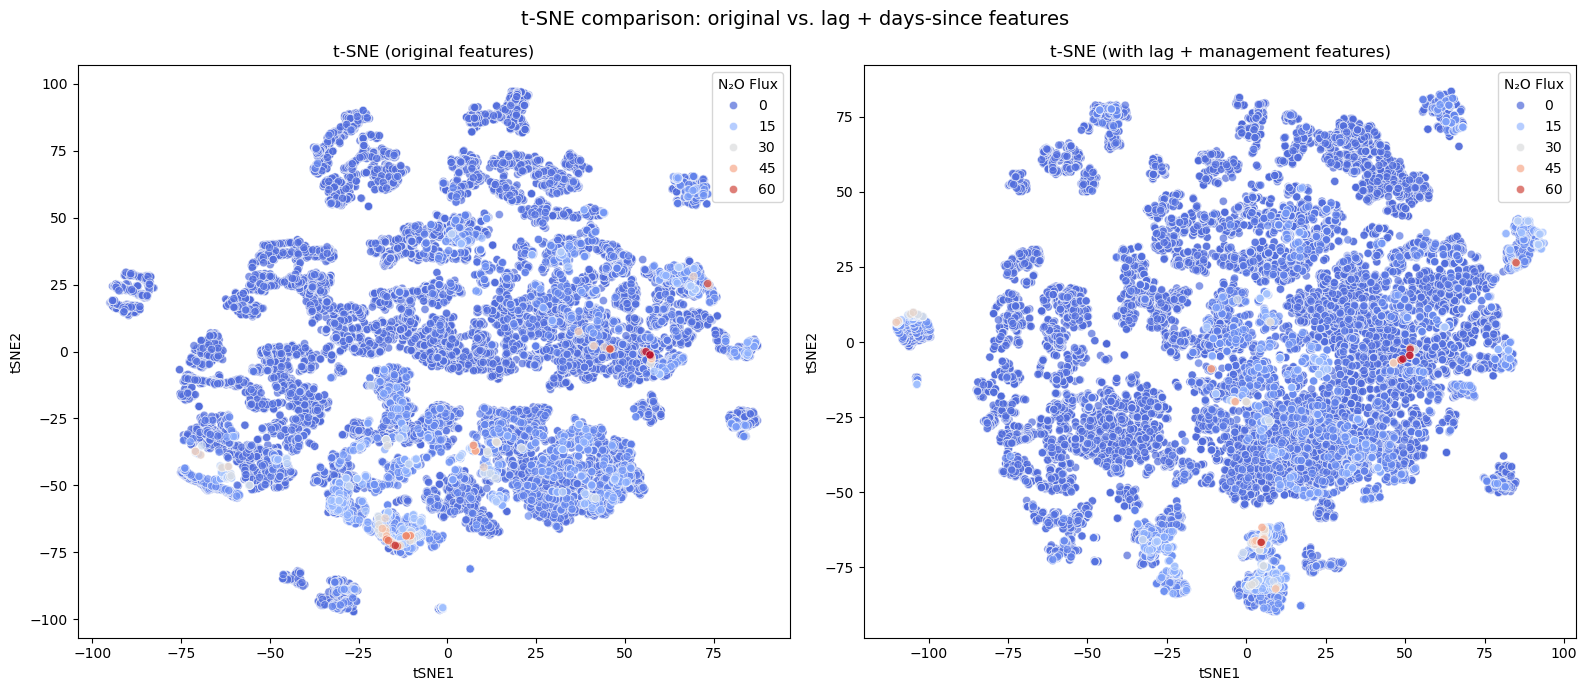

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------
# --- 1️⃣ t-SNE on original chamau ---
# ---------------------------------
chamau_clean = chamau.dropna(subset=["N2O_Flux"]).dropna()
chamau_clean = chamau_clean.sort_values(by="N2O_Flux", ascending=True)

X_orig = chamau_clean.drop(columns=["N2O_Flux", "Timestamp"])
y_orig = chamau_clean["N2O_Flux"]
X_orig = X_orig.select_dtypes(include=[np.number])

X_scaled_orig = StandardScaler().fit_transform(X_orig)

tsne_orig = TSNE(n_components=2, perplexity=90, random_state=42)
X_tsne_orig = tsne_orig.fit_transform(X_scaled_orig)

tsne_df_orig = pd.DataFrame(X_tsne_orig, columns=["tSNE1", "tSNE2"])
tsne_df_orig["N2O_Flux"] = y_orig.values


# ---------------------------------
# --- 2️⃣ t-SNE on chamau_lag ---
# ---------------------------------
chamau_clean_lag = chamau_lag.dropna(subset=["N2O_Flux"]).dropna()
chamau_clean_lag = chamau_clean_lag.sort_values(by="N2O_Flux", ascending=True)

X_lag = chamau_clean_lag.drop(columns=["N2O_Flux", "Timestamp"])
y_lag = chamau_clean_lag["N2O_Flux"]
X_lag = X_lag.select_dtypes(include=[np.number])

X_scaled_lag = StandardScaler().fit_transform(X_lag)

tsne_lag = TSNE(n_components=2, perplexity=90, random_state=42)
X_tsne_lag = tsne_lag.fit_transform(X_scaled_lag)

tsne_df_lag = pd.DataFrame(X_tsne_lag, columns=["tSNE1", "tSNE2"])
tsne_df_lag["N2O_Flux"] = y_lag.values


# ---------------------------------
# --- 3️⃣ Plot side by side ---
# ---------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16,7), sharex=False, sharey=False)

sns.scatterplot(
    data=tsne_df_orig,
    x="tSNE1", y="tSNE2", hue="N2O_Flux",
    palette="coolwarm", s=35, alpha=0.7, ax=axes[0]
)
axes[0].set_title("t-SNE (original features)")
axes[0].legend(title="N₂O Flux")

sns.scatterplot(
    data=tsne_df_lag,
    x="tSNE1", y="tSNE2", hue="N2O_Flux",
    palette="coolwarm", s=35, alpha=0.7, ax=axes[1]
)
axes[1].set_title("t-SNE (with lag + management features)")
axes[1].legend(title="N₂O Flux")

plt.suptitle("t-SNE comparison: original vs. lag + days-since features", fontsize=14)
plt.tight_layout()
plt.show()


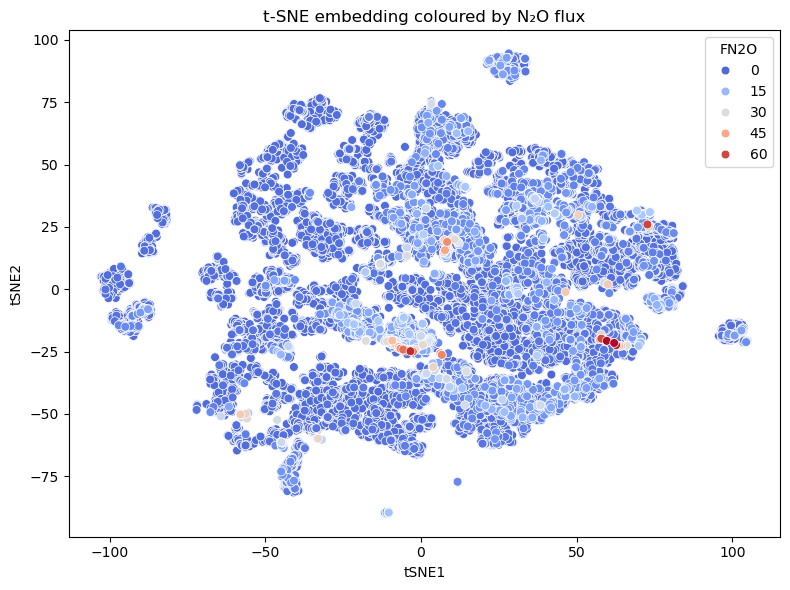

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=90, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(X_tsne, columns=["tSNE1", "tSNE2"])
tsne_df["FN2O"] = y.values

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=tsne_df, x="tSNE1", y="tSNE2",
    hue="FN2O", palette="coolwarm", s=40
)
plt.title("t-SNE embedding coloured by N₂O flux")
plt.tight_layout()
plt.show()
